In [1]:
import numpy as np
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import Draw
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
import math

In [2]:
# load predicted values from the previous 6-fold cross-validation as df
bert_p_1 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune2/hansen_p_bert_ds6_fold1_results_v2.csv')
bert_p_2 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune2/hansen_p_bert_ds5_fold2_results_v2.csv')
bert_p_3 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune2/hansen_p_bert_ds4_fold3_results_v2.csv')
bert_p_4 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune2/hansen_p_bert_ds3_fold4_results.csv')
bert_p_5 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune2/hansen_p_bert_ds2_fold5_results.csv')
bert_p_6 = pd.read_csv('/Users/jiayun/Documents/work/bert_finetune2/hansen_p_bert_ds1_fold6_results.csv')
# concat the data, rename columns (actual=experimentally determined value)
bert = pd.concat((bert_p_1, bert_p_2, bert_p_3, bert_p_4, bert_p_5, bert_p_6), axis=0)

In [3]:
# MAE, AE and RMSE give an idea of the error distribution
print(mean_absolute_error(bert['exp'], bert['predict']))

#RMSEs
print(math.sqrt(mean_squared_error(bert['exp'], bert['predict'])))

# R^2 Coefficient of Determination
print(r2_score(bert['exp'], bert['predict']))

2.243756041964666
3.1355674975738173
0.4739458050184645


In [4]:
len(bert)

1183

In [5]:
# calculate the residual value for each molecule
bert['residual']= bert['predict']-bert['exp']

In [6]:
# calculate standardised deviation of the residuals (sdr) of the dataset
# equations used: sdr = sqrt((sum((residual)**2))/(n-2))
sdr = np.sqrt((bert['residual']**2).sum()/(len(bert)-2))
sdr

3.1382213850548895

In [7]:
# calculate how many sdr each molecule's predicted value is away from the exp value 
bert['std_residual'] = bert['residual']/sdr
bert['std_residual']

0      2.415802
1      0.921493
2      0.288239
3     -0.247943
4      1.150057
         ...   
193   -0.156087
194    0.203476
195    0.050266
196   -0.137377
197    0.523365
Name: std_residual, Length: 1183, dtype: float64

In [8]:
# n is 2 or 3. Points 2 or 3 sdr away from the prediction line are likely to be outliers
n = 3
bert_outliers = bert.loc[abs(bert['std_residual']) > n]
bert_outliers

,Unnamed: 0,smiles,exp,predict,residual,std_residual
73,73,c1ccnnc1,17.4,7.009521,-10.390479,-3.310945
134,134,S=C=S,0.0,11.645076,11.645076,3.710725
23,23,Clc1cc(Cl)c(Cl)cc1Cl,10.7,-0.276907,-10.976907,-3.497812
7,7,C[S](C)=O,16.4,6.213123,-10.186877,-3.246067
4,4,ClC(Cl)(Cl)C=C,15.5,4.957661,-10.542339,-3.359336
38,38,[Ca++].NC#N,27.6,14.148967,-13.451033,-4.286196
51,51,[O-][O+]=O,4.2,15.789057,11.589057,3.692874
72,72,Cl[S](Cl)(=O)=O,7.2,17.777557,10.577557,3.370558
183,183,Nc1ccccn1,8.1,17.554478,9.454478,3.012687
102,102,Cl[S](Cl)=O,6.4,17.968540,11.568540,3.686336


In [9]:
# Set the default text font size
plt.rc('font', size=22)

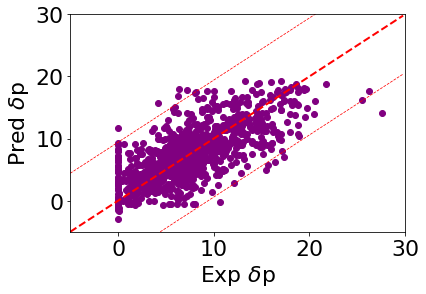

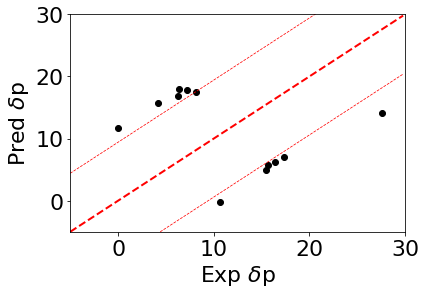

In [10]:
plt.figure(2)

# plot of exp vs pred of all molecules in the dataset
# The thick red lines indicate ideal agreement between the predicted and experimental values. 
# The dashed red lines indicate 3 srd (n=3) away from the ideal agreement. 
ln = np.arange(-5, 30, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert['exp'], y=bert['predict'], color='purple')
plt.xlabel('Exp $\delta$p')
plt.ylabel('Pred $\delta$p')
plt.xlim([-5,30])
plt.ylim([-5,30])
plt.show()

# Plot of the outliers identified 
# check visually to confirm they are on or beyond 3 srd
ln = np.arange(-5, 30, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert_outliers['exp'], y=bert_outliers['predict'], color='black')
plt.xlabel('Exp $\delta$p')
plt.ylabel('Pred $\delta$p')
plt.xlim([-5,30])
plt.ylim([-5,30])
plt.show()

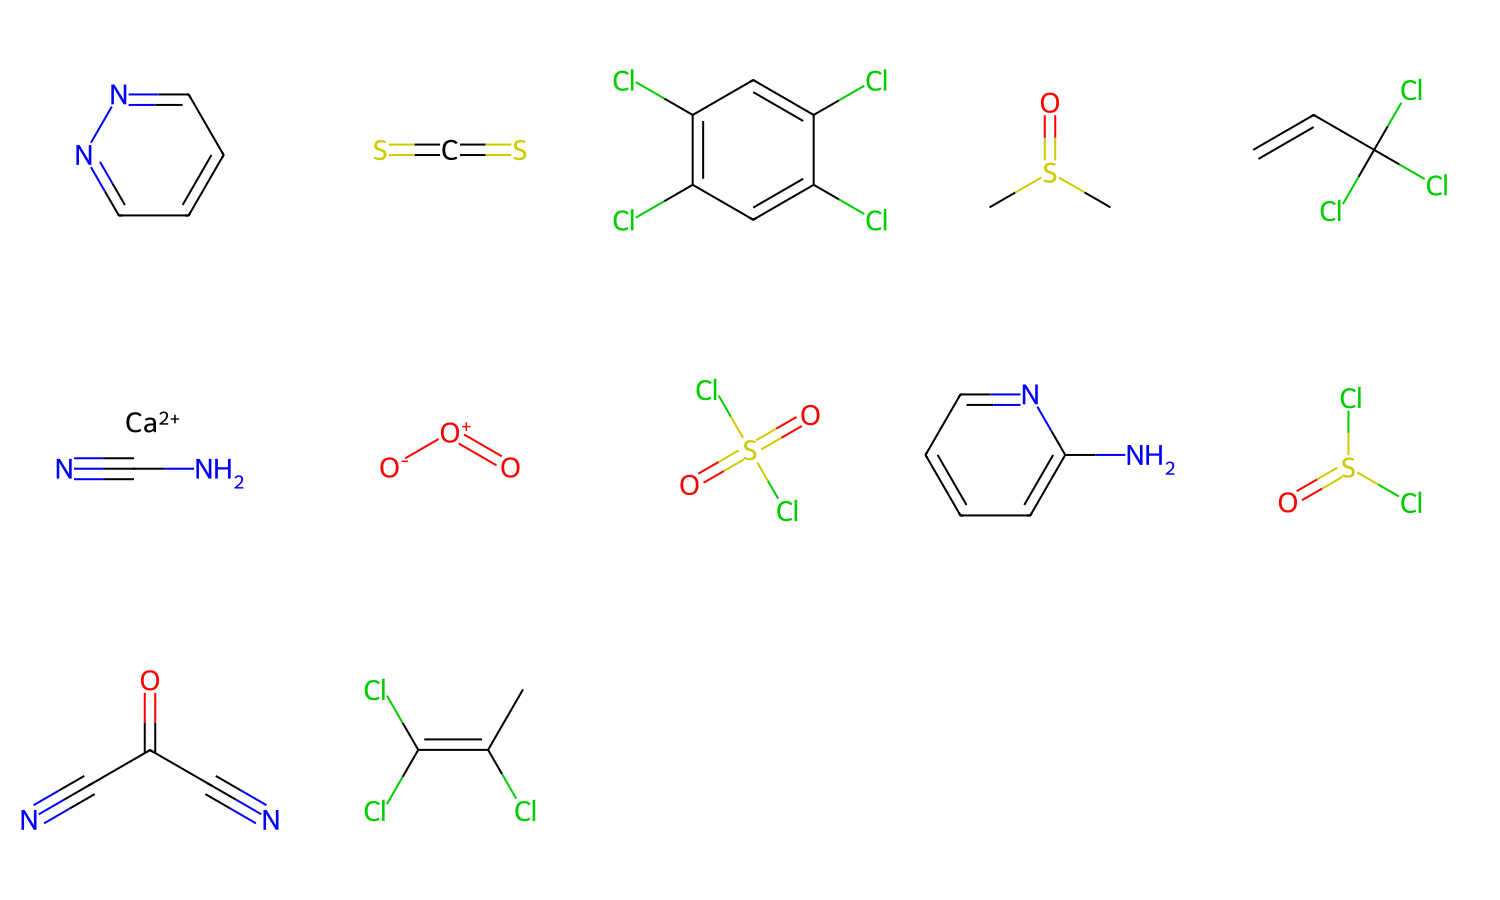

In [11]:
# draw n=3 outlier structure
outliners = [Chem.MolFromSmiles(x) for x in bert_outliers['smiles']]
Draw.MolsToGridImage(outliners, subImgSize=(300,300), molsPerRow=5, maxMols=50)

In [12]:
bert_outliers.to_csv('bert_p_outliers3.csv')

In [13]:
# n is 2 or 3. Points 2 or 3 sdr away from the prediction line are likely to be outliers
n = 2
bert_outliers2 = bert.loc[abs(bert['std_residual']) > n]
bert_outliers2

,Unnamed: 0,smiles,exp,predict,residual,std_residual
0,0,SC#N,8.9,16.481321,7.581321,2.415802
13,13,CC1COC(=O)O1,18.0,11.142934,-6.857066,-2.185017
35,35,O=C1c2ccccc2C(=O)c3ccccc13,7.6,14.006788,6.406788,2.041535
37,37,CC(=C)C(Cl)=O,10.6,4.166772,-6.433228,-2.049960
51,51,CC1=CNC(=O)NC1=O,20.5,13.891396,-6.608604,-2.105844
...,...,...,...,...,...,...
106,106,O=C(C#N)C#N,6.3,16.933725,10.633725,3.388456
112,112,CC(Cl)=C(Cl)Cl,15.7,5.754066,-9.945934,-3.169290
120,120,BrC(Br)=C,4.8,11.638297,6.838297,2.179036
146,146,Cc1ccc(c(c1[N+]([O-])=O)[N+]([O-])=O)[N+]([O-])=O,3.5,11.235797,7.735797,2.465026


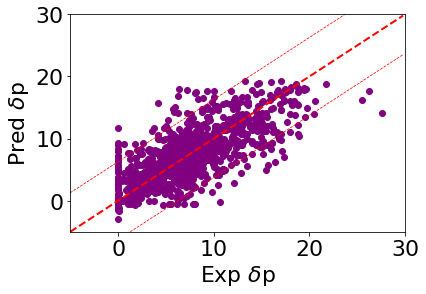

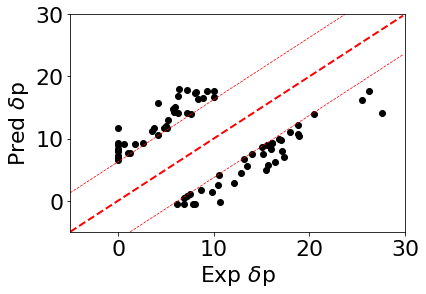

In [14]:
plt.figure(2)

# plot of exp vs pred of all molecules in the dataset
# The thick red lines indicate ideal agreement between the predicted and experimental values. 
# The dashed red lines indicate 2 srd (n=2) away from the ideal agreement. 
ln = np.arange(-5, 30, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert['exp'], y=bert['predict'], color='purple')
plt.xlabel('Exp $\delta$p')
plt.ylabel('Pred $\delta$p')
plt.xlim([-5,30])
plt.ylim([-5,30])
plt.show()

# Plot of the outliers identified 
# check visually to confirm they are on or beyond 2 srd
ln = np.arange(-5, 30, 0.2)
plt.plot(ln, ln,'r--', linewidth = '2')
plt.plot(ln, ln+n*sdr,'r--', linewidth = '0.75')
plt.plot(ln, ln-n*sdr,'r--', linewidth = '0.75')
plt.scatter(x=bert_outliers2['exp'], y=bert_outliers2['predict'], color='black')
plt.xlabel('Exp $\delta$p')
plt.ylabel('Pred $\delta$p')
plt.xlim([-5,30])
plt.ylim([-5,30])
plt.show()

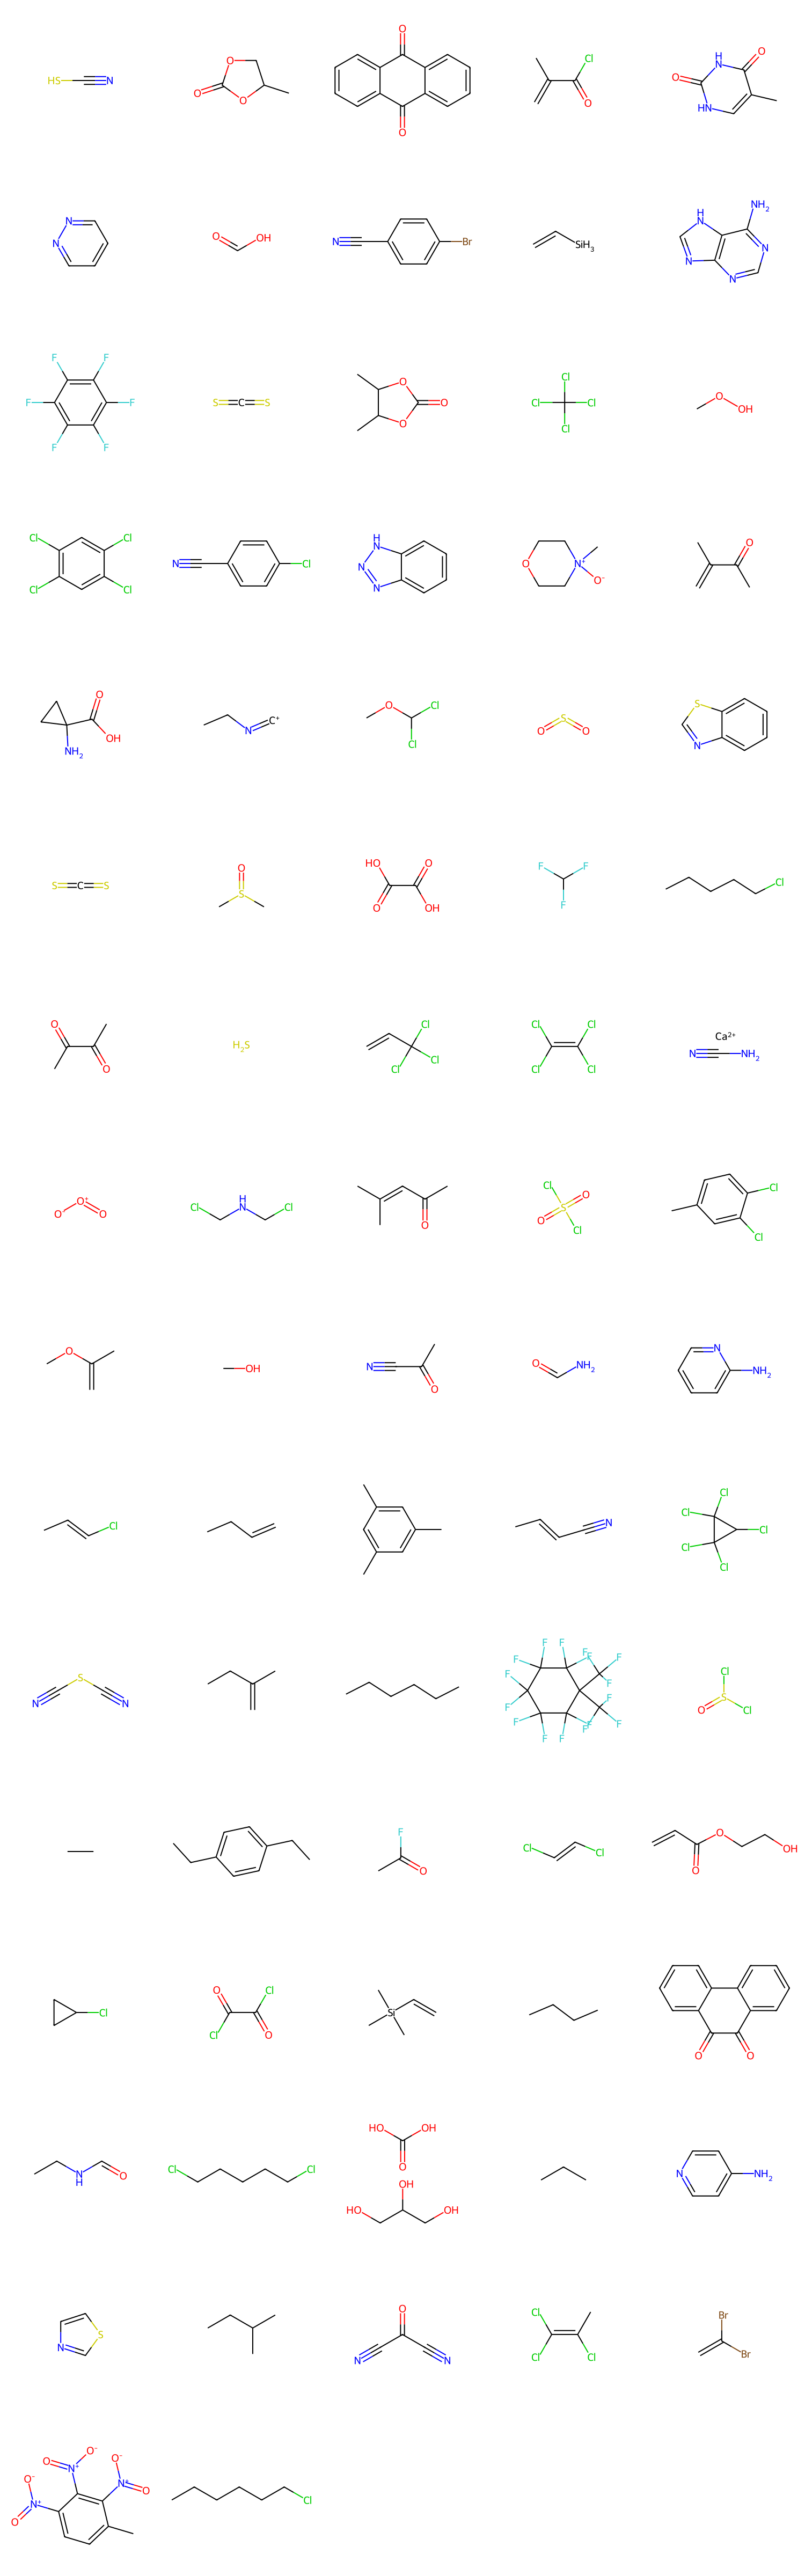

In [17]:
# draw n=2 outlier structure
outliners2 = [Chem.MolFromSmiles(x) for x in bert_outliers2['smiles']]
Draw.MolsToGridImage(outliners2, subImgSize=(300,300), molsPerRow=5, maxMols=100)

In [18]:
# save outliers (n=2) info to a csv file
bert_outliers2.to_csv('bert_p_outliers2.csv')

In [19]:
from rdkit.Chem import Descriptors
gpHSP_data = pd.read_csv('/Users/jiayun/Documents/work/mol2vec/hansen_1k_smiles_shorter.csv')
mol_smiles = gpHSP_data['SMILES']

# calculate molecular weight of the full dataset
molwt = [(Descriptors.ExactMolWt(Chem.MolFromSmiles(x))) for x in gpHSP_data['SMILES']]
np_molwt = np.asarray(molwt)

# calculate molecular weight of outliers
molwt_outliers2 = [(Descriptors.ExactMolWt(Chem.MolFromSmiles(x))) for x in bert_outliers2['smiles']]
np_molwt_outliers2 = np.asarray(molwt_outliers2)

# Compare average molecular weight for full data and outliers
print(np.average(np_molwt))
print(np.average(np_molwt_outliers2))

131.2953603288794
108.12622866873079


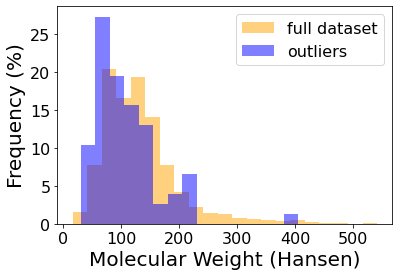

In [20]:
# plot molecular weight distribution for the full dataset and the outliers
bin_width = 25
df = pd.DataFrame(np_molwt, columns = ["full dataset"])
df2 = pd.DataFrame(np_molwt_outliers2, columns = ["outliers"])

ax = df.plot.hist(bins=(np.arange(min(molwt), max(molwt)+bin_width, bin_width)), alpha=0.5, color='orange', weights=np.ones_like(df.index) *100/ len(df))
df2.plot(kind='hist', bins=(np.arange(min(molwt_outliers2), max(molwt_outliers2)+bin_width, bin_width)), alpha=0.5, color='blue', weights=np.ones_like(df2.index) *100 /len(df2), ax=ax)
ax.set_xlabel("Molecular Weight (Hansen)", size=20)
ax.set_ylabel("Frequency (%)", size=20)
plt.show()